In [31]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
from tesserocr import PyTessBaseAPI
import os
from PIL import Image
import json
import string
import pandas as pd

In [32]:
class cv_data_conversion: 
    def __init__(self):
        pass
    
    class template_mode:
        def __init_(self):
            pass
        
        def process_template(self, template_path, export_path):
            template_path = r"{}".format(template_path)
            export_path = r"{}".format(export_path)
            
            img =  cv2.imread(template_path)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            thresh_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
            # Blur the image
            blur = cv2.GaussianBlur(thresh_inv,(1,1),0)
            thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
            # find contours
            cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
            
            data = []
            
            for cnt in cnts: 
                approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)

                if len(approx) == 4: 
                    coord_and_data = []

                    x, y, w, h = cv2.boundingRect(cnt)

                    c1 = y
                    c2 = y+h
                    c3 = x
                    c4 = x+w

                    # Cropping
                    image_arr = gray
                    image_arr = image_arr[c1:c2, c3:c4]
                    image_arr = cv2.resize(image_arr, (image_arr.shape[1]*2, image_arr.shape[0]*2))

                    
                    black = 0
                    white = 255
                    threshold = 160
                    
                    # Compare each pixel 
                    for i in range(len(image_arr)):
                        for j in range(len(image_arr[i])):
                            if image_arr[i][j] < threshold:
                                image_arr[i][j] = black
                            else:
                                image_arr[i][j] = white
                    
                    plt.imshow(image_arr)
                    plt.show()

                    # Saving coordinates
                    coord_and_data.append([c1, c2, c3, c4])

                    # Temporary saving image for OCR processing
                    im = Image.fromarray(image_arr)
                    im.save(r"..\..\temp\image_arr.jpeg")

                    # OCR process
                    with PyTessBaseAPI(path=r'..\..\Tessdata', lang='eng_best') as api:
                        api.SetImageFile(r"..\..\temp\image_arr.jpeg")
                        coord_and_data.append([api.GetUTF8Text()])
                        print(api.GetUTF8Text())

                    # Deleting image    
                    os.remove(r"..\..\temp\image_arr.jpeg") 

                    # Saving data of text
                    data.append(coord_and_data)
                    
                    template = {
                      "image_dimension": thresh.shape,
                      "data_fields": data,
                    }

                    template_json = json.dumps(template)

                    with open(export_path, "w") as outfile:
                        json.dump(template_json, outfile)
                        
                        
        def template_usage(self, template_path, data_path, export_path):
            template_path = r"{}".format(template_path)
            data_path = r"{}".format(data_path)
            export_path = r"{}".format(export_path)
            
            #loading the template
            template = json.loads(open(template_path).read())
            template = json.loads(template)

            template_dimension = template.get("image_dimension")
            template_data_fields = template.get("data_fields")

            
            # iterate over files in that directory
            directory = data_path
            files = []
            filenames = []
            
            for filename in os.listdir(directory):
                f = os.path.join(directory, filename)
                # checking if it is a file
                if os.path.isfile(f):
                    files.append(f)
                    filenames.append(filename)

            data = {}        

            for h in range(len(files)):
                path = r"{}".format(files[h])

                #loading the image
                img =  cv2.imread(path)
                gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

                thresh_inv = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

                # Blur the image
                blur = cv2.GaussianBlur(thresh_inv,(1,1),0)

                thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

                #resizing image to match the template
                thresh = cv2.resize(thresh, (template_dimension[1], template_dimension[0]))


                temp_data = {}

                for i in range(len(template_data_fields)):

                        c1, c2, c3, c4 = template_data_fields[i][0][0], template_data_fields[i][0][1], template_data_fields[i][0][2], template_data_fields[i][0][3]
                        image_arr = thresh
                        image_arr = image_arr[c1:c2, c3:c4]
                        image_arr = cv2.resize(image_arr, (image_arr.shape[1]*1, image_arr.shape[0]*1))
                        
                        print(image_arr.shape())
                        
                        black = 0
                        white = 255
                        threshold = 160
                        
                        # Compare each pixel 
                        for i in range(len(image_arr)):
                            for j in range(len(image_arr[i])):
                                if image_arr[i][j] < threshold:
                                    image_arr[i][j] = black
                                else:
                                    image_arr[i][j] = white
            
                        # Temporary saving cropped image for OCR processing
                        im = Image.fromarray(image_arr)
                        #plt.imshow(image_arr)
                        #plt.show()
                        im.save(r"..\..\temp\image_arr.jpeg")

                        # OCR process
                        with PyTessBaseAPI(path=r'..\..\Tessdata', lang='eng_best') as api:
                            api.SetImageFile(r"..\..\temp\image_arr.jpeg")
                            temp_data[template_data_fields[i][1][0]] = api.GetUTF8Text()

                data[filenames[h]] = temp_data
                
            #exporting data    
            data_json = json.dumps(data)

            with open(r"C:\Users\brans\Downloads\data.json", "w") as outfile:
                json.dump(data_json, outfile)
                
                
    class spreadsheet_mode: 
        def __init__(self):
            pass
        
        def spreadsheet_capture(self, image_path, export_path):
            image_path = r"{}".format(image_path)
            export_path = r"{}".format(export_path)
            
            with PyTessBaseAPI(path = r'..\..\Tessdata', lang='eng_best') as api:
                api.SetImageFile(image_path)
                text = api.GetUTF8Text()
                text = text.replace("\n", " xxx ")
                text = text.split()
                

                array = []
                temp_array = []
                count = 0

                while count < len(text):
                    if text[count] == 'xxx':
                        array.append(temp_array)
                        temp_array = []
                    else: 
                        temp_array.append(text[count])

                    count = count + 1
                    
            df = pd.DataFrame(array)
            df.to_csv(export_path, index=False)
                
                

In [33]:
template_file = r"C:\Users\brans\OneDrive\Documents\Application-files-utilities\VScode\Project-007\TemplateModeAlphaTesting\Template.jpg"
template_json = r"C:\Users\brans\Downloads\template.json"
files_to_capture = r"C:\Users\brans\OneDrive\Documents\Application-files-utilities\VScode\Project-007\TemplateModeAlphaTesting\Data"
data_export = r"C:\Users\brans\Downloads\data.json"

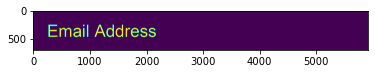

=H ENFAYe lo [51S



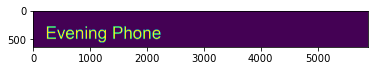

=VTallaleMmdalelsl=



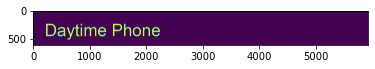

DEVI [CR glelplS



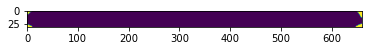

PP



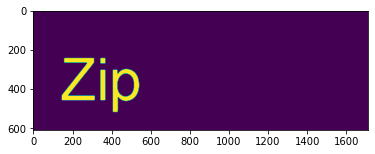

Ale



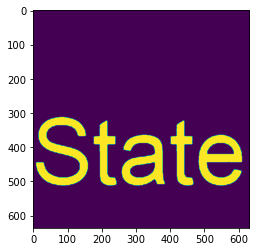

State



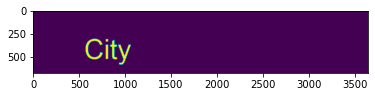

City



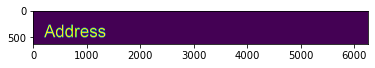

Address



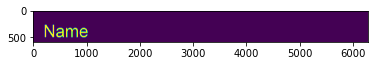

NETIC



In [34]:
converter = cv_data_conversion().template_mode().process_template(template_file, template_json)

In [21]:
process_image = cv_data_conversion().template_mode().template_usage(template_json, files_to_capture, data_export)

TypeError: 'tuple' object is not callable

In [49]:
image_path = r"C:\Users\brans\Documents\Application-files-utilities\VScode\Project-007\Data-storage\spreadsheet-1.jpg"
spreadsheet_export_path = r"C:\Users\brans\Downloads\spreadsheet.csv"

In [27]:
spreadsheet_process = cv_data_conversion().spreadsheet_mode().spreadsheet_capture(image_path, spreadsheet_export_path)